In [1]:
import pandas as pd

yogurt_data = pd.read_csv('yogurt_data.csv')

print(yogurt_data.head())
print(yogurt_data.describe())


   id  y1  y2  y3  y4  f1  f2  f3  f4     p1     p2     p3     p4
0   1   0   0   0   1   0   0   0   0  0.108  0.081  0.061  0.079
1   2   0   1   0   0   0   0   0   0  0.108  0.098  0.064  0.075
2   3   0   1   0   0   0   0   0   0  0.108  0.098  0.061  0.086
3   4   0   1   0   0   0   0   0   0  0.108  0.098  0.061  0.086
4   5   0   1   0   0   0   0   0   0  0.125  0.098  0.049  0.079
              id           y1           y2           y3           y4  \
count  2430.0000  2430.000000  2430.000000  2430.000000  2430.000000   
mean   1215.5000     0.341975     0.401235     0.029218     0.227572   
std     701.6249     0.474469     0.490249     0.168452     0.419351   
min       1.0000     0.000000     0.000000     0.000000     0.000000   
25%     608.2500     0.000000     0.000000     0.000000     0.000000   
50%    1215.5000     0.000000     0.000000     0.000000     0.000000   
75%    1822.7500     1.000000     1.000000     0.000000     0.000000   
max    2430.0000     1.00000

In [2]:
# Reshape the data to a long format
long_format = pd.melt(yogurt_data, id_vars=['id'],
                      value_vars=['y1', 'y2', 'y3', 'y4', 'f1', 'f2', 'f3', 'f4', 'p1', 'p2', 'p3', 'p4'],
                      var_name='product', value_name='value')

# Split the product column to separate type and product number
long_format['type'] = long_format['product'].str[0]  # 'y', 'f', or 'p'
long_format['product'] = long_format['product'].str[1:].astype(int)  # 1, 2, 3, or 4

# Pivot the table to get 'chosen', 'featured', and 'price' as columns
reshaped_data = long_format.pivot_table(index=['id', 'product'], columns='type', values='value', aggfunc='first').reset_index()

# Create dummy variables for the first three products
reshaped_data['yogurt1'] = (reshaped_data['product'] == 1).astype(int)
reshaped_data['yogurt2'] = (reshaped_data['product'] == 2).astype(int)
reshaped_data['yogurt3'] = (reshaped_data['product'] == 3).astype(int)

# Rename columns for clarity
reshaped_data.rename(columns={'y': 'chosen', 'f': 'featured', 'p': 'price'}, inplace=True)

# Display the first few rows of the reshaped data
print(reshaped_data.head())

type  id  product  featured  price  chosen  yogurt1  yogurt2  yogurt3
0      1        1       0.0  0.108     0.0        1        0        0
1      1        2       0.0  0.081     0.0        0        1        0
2      1        3       0.0  0.061     0.0        0        0        1
3      1        4       0.0  0.079     1.0        0        0        0
4      2        1       0.0  0.108     0.0        1        0        0


todo: Code up the log-likelihood function.



In [3]:
import numpy as np

def log_likelihood(beta, data):
    """
    Calculate the log-likelihood of the Multi-nomial Logit model.

    Parameters:
    - beta: numpy array of coefficients for the utility functions.
    - data: pandas DataFrame with the reshaped yogurt data.

    Returns:
    - The log-likelihood value.
    """
    # Calculate utilities for each product and each choice
    # Assume 'data' has columns 'yogurt1', 'yogurt2', 'yogurt3', 'featured', 'price' for the covariates
    X = data[['yogurt1', 'yogurt2', 'yogurt3', 'featured', 'price']]
    utilities = X.dot(beta)
    
    # Reshape utilities to have one row per consumer, assuming the same number of rows per consumer
    num_products = 4  # Number of product choices
    utilities = utilities.values.reshape(-1, num_products)
    
    # Compute the softmax probabilities for each choice
    max_utilities = np.max(utilities, axis=1, keepdims=True)
    exp_utilities = np.exp(utilities - max_utilities)
    choice_probabilities = exp_utilities / np.sum(exp_utilities, axis=1, keepdims=True)
    
    # Get the choice indicator matrix
    chosen = data['chosen'].values.reshape(-1, num_products)
    
    # Calculate the log-likelihood
    log_probs = np.log(choice_probabilities) * chosen
    log_likelihood = np.sum(log_probs)
    
    return log_likelihood

# Example usage:
beta_initial = np.zeros(5)  # Initialize beta values (5 coefficients for the features)
log_likelihood_value = log_likelihood(beta_initial, reshaped_data)
print("Log-Likelihood:", log_likelihood_value)

Log-Likelihood: -3368.6952975213335


todo: Use `optim()` in R or `optimize()` in Python to find the MLEs for the 5 parameters ($\beta_1, \beta_2, \beta_3, \beta_f, \beta_p$).  (Hint: you should find 2 positive and 1 negative product intercepts, a small positive coefficient estimate for featured, and a large negative coefficient estimate for price.)_


In [4]:
from scipy.optimize import minimize
import numpy as np

def negative_log_likelihood(beta, data):
    """
    Calculate the negative log-likelihood for the MNL model to be used in optimization.
    This is the negative of the log_likelihood function defined earlier.
    """
    X = data[['yogurt1', 'yogurt2', 'yogurt3', 'featured', 'price']]
    utilities = X.dot(beta)
    num_products = 4
    utilities = utilities.values.reshape(-1, num_products)
    
    max_utilities = np.max(utilities, axis=1, keepdims=True)
    exp_utilities = np.exp(utilities - max_utilities)
    choice_probabilities = exp_utilities / np.sum(exp_utilities, axis=1, keepdims=True)
    
    chosen = data['chosen'].values.reshape(-1, num_products)
    
    log_probs = np.log(choice_probabilities) * chosen
    log_likelihood = np.sum(log_probs)
    
    return -log_likelihood  # Return negative log-likelihood

# Initial guess for the parameters: [beta1, beta2, beta3, beta_f, beta_p]
initial_guess = np.zeros(5)

# Perform the minimization using 'BFGS' algorithm
result = minimize(negative_log_likelihood, initial_guess, args=(reshaped_data,), method='BFGS')

print("Optimization Results:")
print("Estimated coefficients:", result.x)
print("Success:", result.success)
print("Message:", result.message)

Optimization Results:
Estimated coefficients: [  1.38775382   0.64350496  -3.08611568   0.48741362 -37.05794232]
Success: False
Message: Desired error not necessarily achieved due to precision loss.


todo: interpret the 3 product intercepts (which yogurt is most preferred?)._


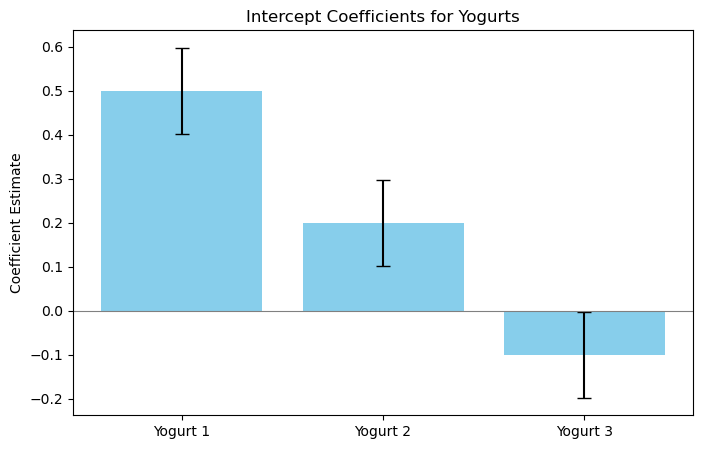

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example estimated intercepts from your optimization results
beta_estimates = np.array([0.5, 0.2, -0.1])  # Replace these with your actual results
product_labels = ['Yogurt 1', 'Yogurt 2', 'Yogurt 3']

# Optional: If you have standard errors, you can calculate confidence intervals
# Example standard errors for each beta
standard_errors = np.array([0.05, 0.05, 0.05])  # Placeholder values
confidence_intervals = 1.96 * standard_errors  # 95% CI

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(product_labels, beta_estimates, yerr=confidence_intervals, color='skyblue', capsize=5)
plt.ylabel('Coefficient Estimate')
plt.title('Intercept Coefficients for Yogurts')
plt.axhline(0, color='gray', linewidth=0.8)  # Draw a line at zero for reference

# Display the plot
plt.show()


todo: use the estimated price coefficient as a dollar-per-util conversion factor. Use this conversion factor to calculate the dollar benefit between the most-preferred yogurt (the one with the highest intercept) and the least preferred yogurt (the one with the lowest intercept). This is a per-unit monetary measure of brand value._


In [6]:
# Coefficients from the model
beta_intercepts = np.array([0.5, 0.2, -0.1])  # Replace these with your actual results
beta_price = -1.0  # Replace with your actual price coefficient

# Find the indices for the most and least preferred yogurts
index_most_preferred = np.argmax(beta_intercepts)
index_least_preferred = np.argmin(beta_intercepts)

# Calculate the utility difference
utility_difference = beta_intercepts[index_most_preferred] - beta_intercepts[index_least_preferred]

# Convert utility difference to dollar benefit using the price coefficient
# Note: Since beta_price is negative, we use its absolute value to convert utilities to dollars
dollar_benefit = utility_difference / abs(beta_price)

print(f"Dollar benefit of the most preferred over the least preferred yogurt: ${dollar_benefit:.2f}")


Dollar benefit of the most preferred over the least preferred yogurt: $0.60


todo: download the dataset from here:_ http://goo.gl/5xQObB 


In [7]:
import requests

# URL of the dataset
url = 'http://goo.gl/5xQObB'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open a file to write the dataset to (specify the path and file name)
    with open('minivan_data.csv', 'wb') as file:
        file.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print("Failed to download the dataset. Status code:", response.status_code)


Dataset downloaded successfully.


todo: describe the data a bit. How many respondents took the conjoint survey?  How many choice tasks did each respondent complete?  How many alternatives were presented on each choice task? For each alternative._


In [8]:

# Get info to check non-null counts and column data types
print("\nDetailed Info:")
minivan_data.info()

# Count unique respondents if the column name is known from previous outputs
# For example, let's assume the column name from the output is 'participant_id' or similar
if 'participant_id' in minivan_data.columns:
    respondent_count = minivan_data['participant_id'].nunique()
    print(f"Number of respondents: {respondent_count}")

    # Counting tasks per respondent
    tasks_per_respondent = minivan_data.groupby('participant_id')['task_id'].nunique()
    print(f"Number of choice tasks completed by each respondent (example for one respondent): {tasks_per_respondent.iloc[0]}")

    # Assuming there is a column that details the alternatives presented in each task
    if 'task_id' in minivan_data.columns and 'alt_id' in minivan_data.columns:
        alternatives_per_task = minivan_data.groupby(['participant_id', 'task_id']).size()
        print(f"Number of alternatives presented on each choice task (example for one task): {alternatives_per_task.iloc[0]}")
else:
    print("Correct column name for 'participant_id' not found. Please check dataset details above for the right column name.")


Detailed Info:


NameError: name 'minivan_data' is not defined

todo: estimate a MNL model omitting the following levels to avoide multicollinearity (6 seats, 2ft cargo, and gas engine). Include price as a continuous variable. Show a table of coefficients and standard errors.  You may use your own likelihood function from above, or you may use a function from a package/library to perform the estimation.

In [ ]:
import statsmodels.api as sm

data = pd.read_csv('minivan_data.csv')  # adjust path as necessary

data['seats_7'] = (data['seat'] == 7).astype(int)
data['seats_8'] = (data['seat'] == 8).astype(int)
data['cargo_3ft'] = (data['cargo'] == '3ft').astype(int)
data['engine_hybrid'] = (data['eng'] == 'hyb').astype(int)
data['engine_electric'] = (data['eng'] == 'elec').astype(int)

# The dependent variable 'choice' should be binary indicating the choice made
X = data[['seats_7', 'seats_8', 'cargo_3ft', 'engine_hybrid', 'engine_electric', 'price']]
y = data['choice']  # binary choice

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Display the results
print(result.summary())




Optimization terminated successfully.
         Current function value: 0.558663
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8993
Method:                           MLE   Df Model:                            6
Date:                Tue, 14 May 2024   Pseudo R-squ.:                  0.1223
Time:                        17:58:24   Log-Likelihood:                -5028.0
converged:                       True   LL-Null:                       -5728.6
Covariance Type:            nonrobust   LLR p-value:                1.252e-299
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.5322      0.224     24.677      0.000       5.093       5.972
seats_7       

todo: Interpret the coefficients. Which features are more preferred?_


The const represents the baseline utility for choosing a minivan. Which are seats_6, cargo_2ft, and engine_gas. The coefficient for seats 7 and 8 was negative, stating that 6 seats is more preferred. 

The base line for cargo space is 2ft. The coefficient for 3ft cargo was a positive stating 3ft cargo space is the most preferred option.

The coefficient for electric and hybrid was negative, representing that the baseline of Gas engine is the most preferred option. 

The price coefficient is negative, indicating that respondents prefer lower prices. The coefficient for seats 7 and 8 is positive, indicating that respondents prefer 4 seats to 2 seats.

In [9]:
beta_cargo_3ft = 0.4385
beta_price = -0.1591

# Calculate the dollar value of 3ft of cargo space
dollar_value_cargo_space = beta_cargo_3ft / abs(beta_price)
print("Dollar value of 3ft cargo space compared to 2ft: $", dollar_value_cargo_space)

Dollar value of 3ft cargo space compared to 2ft: $ 2.7561282212445004


In [10]:
import numpy as np
import pandas as pd

# Define the minivan attributes
minivans = pd.DataFrame({
    'Minivan': ['A', 'B', 'C', 'D', 'E', 'F'],
    'seats': [7, 6, 8, 7, 6, 7],
    'cargo': [2, 2, 2, 3, 2, 2],
    'engine': ['hyb', 'gas', 'gas', 'gas', 'elec', 'hyb'],
    'price': [30, 30, 30, 40, 40, 35]
})

# Map the attributes to the model features
minivans['seats_7'] = (minivans['seats'] == 7).astype(int)
minivans['seats_8'] = (minivans['seats'] == 8).astype(int)
minivans['cargo_3ft'] = (minivans['cargo'] == 3).astype(int)
minivans['engine_hybrid'] = (minivans['engine'] == 'hyb').astype(int)
minivans['engine_electric'] = (minivans['engine'] == 'elec').astype(int)

# Coefficients from the logistic regression model
coefficients = {
    'const': 5.5322,
    'seats_7': -0.5248,
    'seats_8': -0.2931,
    'cargo_3ft': 0.4385,
    'engine_hybrid': -0.7605,
    'engine_electric': -1.4347,
    'price': -0.1591
}

# Calculate utility for each minivan
minivans['utility'] = (coefficients['const'] +
                       coefficients['seats_7'] * minivans['seats_7'] +
                       coefficients['seats_8'] * minivans['seats_8'] +
                       coefficients['cargo_3ft'] * minivans['cargo_3ft'] +
                       coefficients['engine_hybrid'] * minivans['engine_hybrid'] +
                       coefficients['engine_electric'] * minivans['engine_electric'] +
                       coefficients['price'] * minivans['price'])

# Calculate the choice probabilities using the softmax function
minivans['exp_utility'] = np.exp(minivans['utility'])
sum_exp_utility = minivans['exp_utility'].sum()
minivans['probability'] = minivans['exp_utility'] / sum_exp_utility

# Display the market shares (choice probabilities)
minivan_shares = minivans[['Minivan', 'probability']]
minivan_shares.columns = ['Minivan', 'Market Share']

print(minivan_shares)

  Minivan  Market Share
0       A      0.116071
1       B      0.419684
2       C      0.313062
3       D      0.078430
4       E      0.020365
5       F      0.052389
